# Quick Start: Python API

[Documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api)


Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

As an example, let’s look at a time series of the log daily page views for the Wikipedia page for Peyton Manning. We scraped this data using the Wikipediatrend package in R. Peyton Manning provides a nice example because it illustrates some of Prophet’s features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning’s playoff and superbowl appearances). The CSV is available in data folder.

In [1]:
# Python
import pandas as pd
from fbprophet import Prophet

In [2]:
# Python
df = pd.read_csv('../data/raw/PeytonManning/example_wp_log_peyton_manning.csv')
df.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

We fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [3]:
m = Prophet()
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 6 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.

In [4]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19

The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [5]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
3265 2017-01-15  8.206497    7.497735    8.930493
3266 2017-01-16  8.531523    7.790108    9.251639
3267 2017-01-17  8.318930    7.627843    9.051371
3268 2017-01-18  8.151543    7.468147    8.900372
3269 2017-01-19  8.163477    7.400767    8.918570

You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

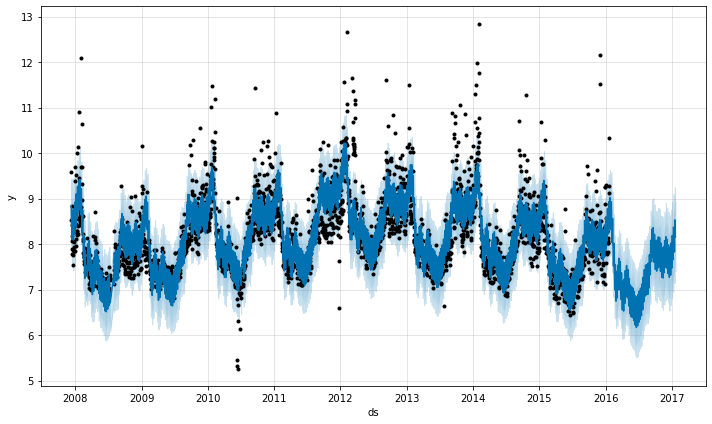

In [6]:
# Python
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

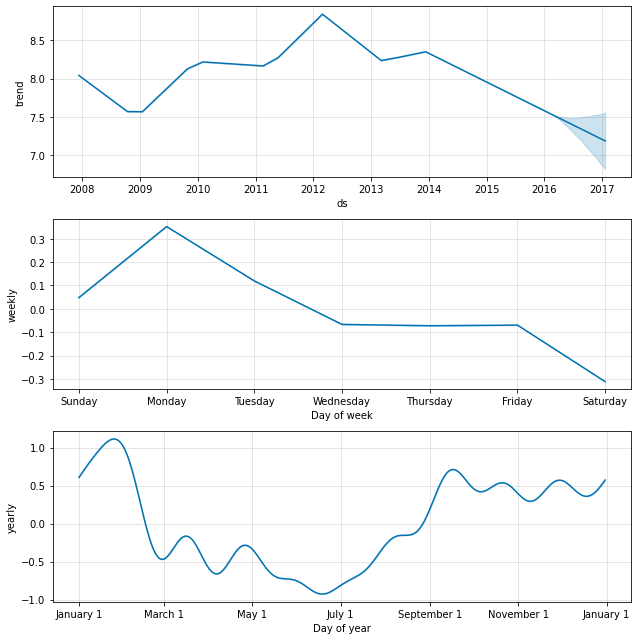

In [7]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast can be created with plotly. You will need to install plotly separately, as it will not by default be installed with fbprophet.

In [8]:
# Python
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

More details about the options available for each method are available in the docstrings, for example, via help(Prophet) or help(Prophet.fit). The R reference manual on CRAN provides a concise list of all of the available functions, each of which has a Python equivalent.

# Saturating Forecasts
## Forecasting Growth
By default, Prophet uses a linear model for its forecast. When forecasting growth, there is usually some maximum achievable point: total market size, total population size, etc. This is called the carrying capacity, and the forecast should saturate at this point.

Prophet allows you to make forecasts using a logistic growth trend model, with a specified carrying capacity.

In [9]:
df = pd.read_csv('../data/raw/PeytonManning/example_wp_log_R.csv')

We must specify the carrying capacity in a column cap. Here we will assume a particular value, but this would usually be set using data or expertise about the market size

In [10]:
# Python
df['cap'] = 8.5

The important things to note are that cap must be specified for every row in the dataframe, and that it does not have to be constant. If the market size is growing, then cap can be an increasing sequence.

We then fit the model as before, except pass in an additional argument to specify logistic growth:

In [11]:
df.describe(include = 'all')

ds            y     cap
count         2863  2863.000000  2863.0
unique        2863          NaN     NaN
top     2015-12-01          NaN     NaN
freq             1          NaN     NaN
mean           NaN     7.113319     8.5
std            NaN     0.675609     0.0
min            NaN     4.077537     8.5
25%            NaN     6.674561     8.5
50%            NaN     7.232010     8.5
75%            NaN     7.637957     8.5
max            NaN     9.057539     8.5

In [12]:
# Python
m = Prophet(growth='logistic')
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


We make a dataframe for future predictions as before, except we must also specify the capacity in the future. Here we keep capacity constant at the same value as in the history, and forecast 5 years into the future:

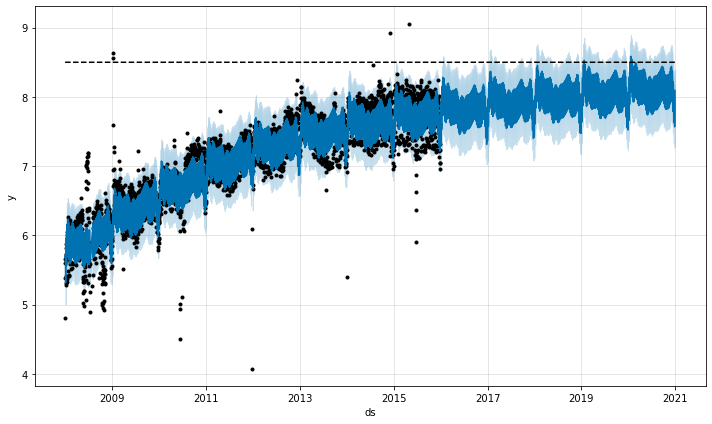

In [13]:
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
fig = m.plot(fcst)

The logistic function has an implicit minimum of 0, and will saturate at 0 the same way that it saturates at the capacity. It is possible to also specify a different saturating minimum.

## Saturating Minimum
The logistic growth model can also handle a saturating minimum, which is specified with a column floor in the same way as the cap column specifies the maximum:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


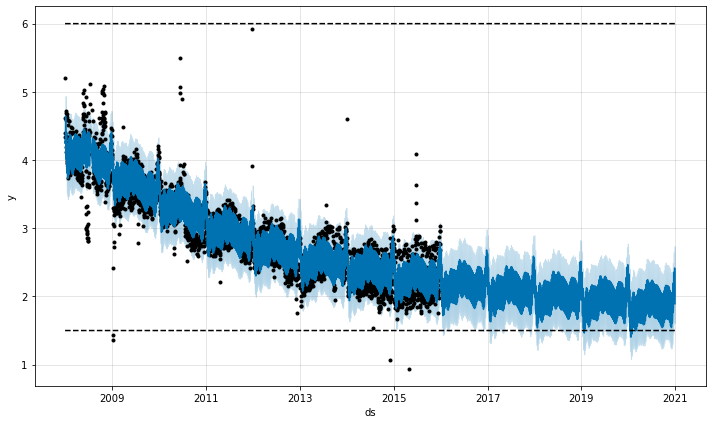

In [14]:
# Python
df['y'] = 10 - df['y']
df['cap'] = 6
df['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5
m = Prophet(growth='logistic')
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.

## Trend Changepoints

You may have noticed in the earlier examples in this documentation that real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

### Automatic changepoint detection in Prophet

Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. 

It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible. 

Consider the Peyton Manning forecast from the Quickstart. By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. 

The vertical lines in this figure indicate where the potential changepoints were placed:

Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused. We can see this by plotting the magnitude of the rate change at each changepoint:

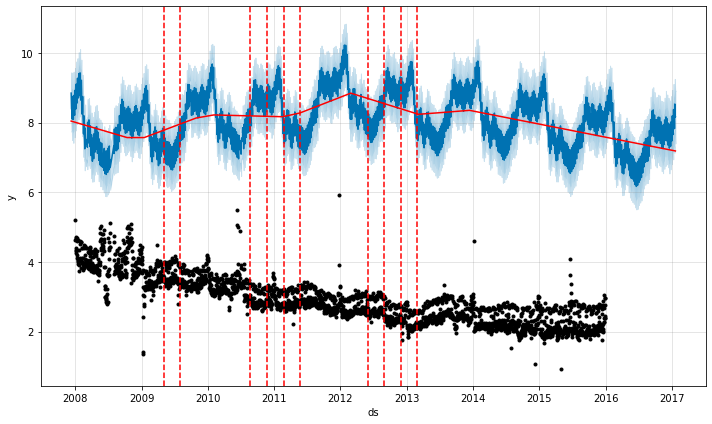

In [15]:
# Python
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. 

This default works in many situations but not all, and can be change using the changepoint_range argument. 

For example, `m = Prophet(changepoint_range=0.9)` in Python or `m <- prophet(changepoint.range = 0.9)` in R will place potential changepoints in the first 90% of the time series.

## Adjusting trend flexibility

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


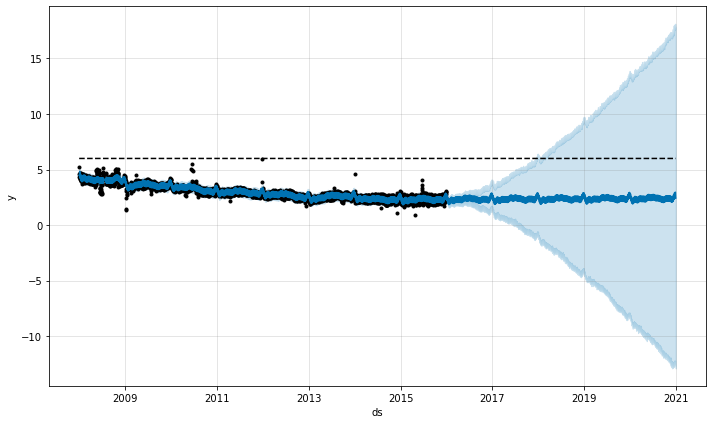

In [16]:
# Python
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

## Specifying the locations of the changepoints

If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the changepoints argument. Slope changes will then be allowed only at these points, with the same sparse regularization as before. One could, for instance, create a grid of points as is done automatically, but then augment that grid with some specific dates that are known to be likely to have changes. As another example, the changepoints could be entirely limited to a small set of dates, as is done here:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


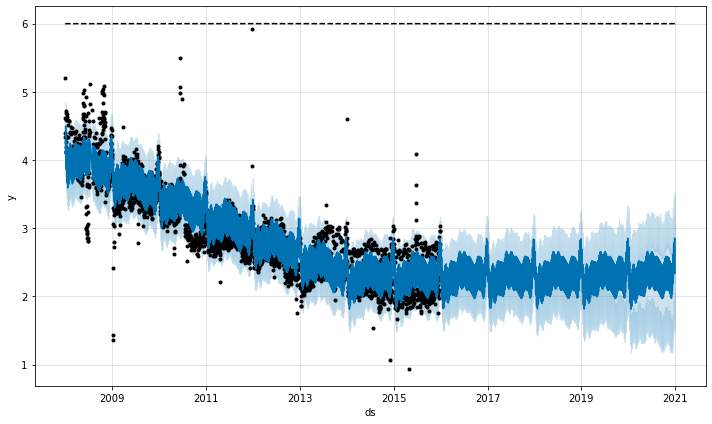

In [17]:
# Python
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

# Seasonality, Holiday Effects, And Regressors

## Modeling Holidays and Special Events

If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. 

It has two columns (holiday and ds) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). 

If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns lower_window and upper_window which extend the holiday out to [lower_window, upper_window] days around the date. For instance, if you wanted to include Christmas Eve in addition to Christmas you’d include lower_window=-1,upper_window=0. If you wanted to use Black Friday in addition to Thanksgiving, you’d include lower_window=0,upper_window=1. You can also include a column prior_scale to set the prior scale separately for each holiday, as described below.

Here we create a dataframe that includes the dates of all of Peyton Manning’s playoff appearances:

In [18]:
# Python
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

Above we have included the superbowl days as both playoff games and superbowl games. This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

Once the table is created, holiday effects are included in the forecast by passing them in with the holidays argument. Here we do it with the Peyton Manning data from the Quickstart:

In [19]:
# Python
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The holiday effect can be seen in the forecast dataframe:

In [20]:
# Python
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

ds   playoff  superbowl
2168 2014-02-02 -0.040707  -0.064323
2169 2014-02-03 -0.026346   0.029068
2510 2015-01-11 -0.040707   0.000000
2511 2015-01-12 -0.026346   0.000000
2879 2016-01-17 -0.040707   0.000000
2880 2016-01-18 -0.026346   0.000000
2886 2016-01-24 -0.040707   0.000000
2887 2016-01-25 -0.026346   0.000000
2900 2016-02-07 -0.040707  -0.064323
2901 2016-02-08 -0.026346   0.029068

The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

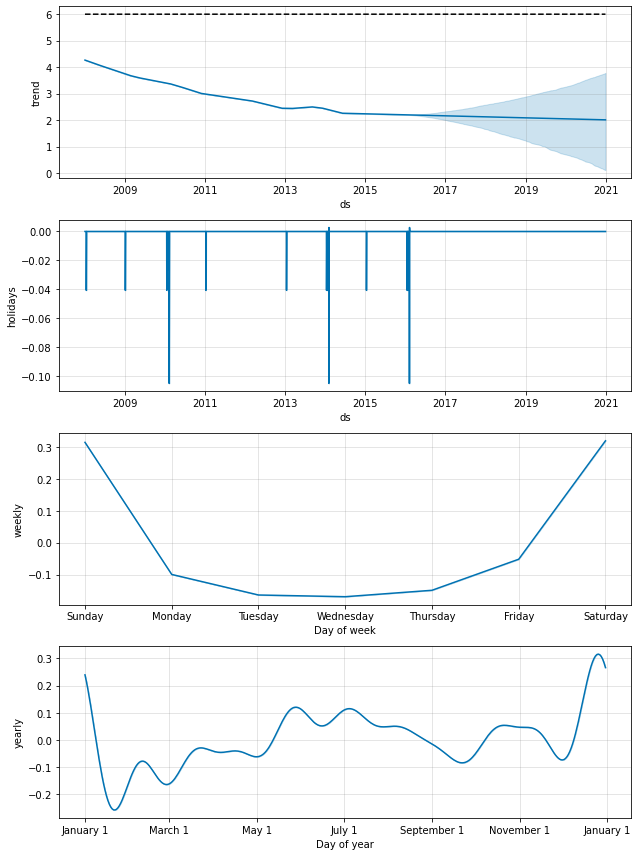

In [22]:
# Python
fig = m.plot_components(forecast)

## Built-in Country Holidays
You can use a built-in collection of country-specific holidays using the add_country_holidays method (Python) or function (R). The name of the country is specified, and then major holidays for that country will be included in addition to any holidays that are specified via the holidays argument described above:

In [23]:
# Python
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


You can see which holidays were included by looking at the train_holiday_names (Python) or train.holiday.names (R) attribute of the model:

In [24]:
# Python
m.train_holiday_names

0                         playoff
1                       superbowl
2                  New Year's Day
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7                       Labor Day
8                    Columbus Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12    Independence Day (Observed)
13      New Year's Day (Observed)
14       Christmas Day (Observed)
15        Veterans Day (Observed)
dtype: object

The holidays for each country are provided by the holidays package in Python. A list of available countries, and the country name to use, is available on their page: https://github.com/dr-prodigy/python-holidays. In addition to those countries, Prophet includes holidays for these countries: Brazil (BR), Indonesia (ID), India (IN), Malaysia (MY), Vietnam (VN), Thailand (TH), Philippines (PH), Turkey (TU), Pakistan (PK), Bangladesh (BD), Egypt (EG), China (CN), and Russian (RU).

The holidays for each country are provided by the holidays package in Python. A list of available countries, and the country name to use, is available on their page: https://github.com/dr-prodigy/python-holidays. In addition to those countries, Prophet includes holidays for these countries: Brazil (BR), Indonesia (ID), India (IN), Malaysia (MY), Vietnam (VN), Thailand (TH), Philippines (PH), Turkey (TU), Pakistan (PK), Bangladesh (BD), Egypt (EG), China (CN), and Russian (RU).

In Python, most holidays are computed deterministically and so are available for any date range; a warning will be raised if dates fall outside the range supported by that country. In R, holiday dates are computed for 1995 through 2044 and stored in the package as data-raw/generated_holidays.csv. If a wider date range is needed, this script can be used to replace that file with a different date range: https://github.com/facebook/prophet/blob/master/python/scripts/generate_holidays_file.py.

As above, the country-level holidays will then show up in the components plot:

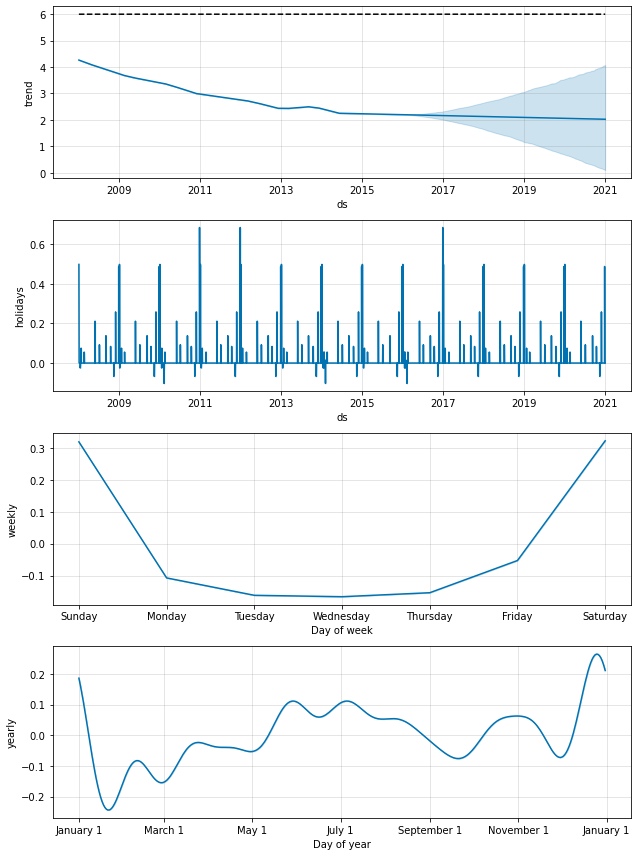

In [25]:
# Python
forecast = m.predict(future)
fig = m.plot_components(forecast)